In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_recall_curve, precision_score, recall_score, f1_score, roc_auc_score


# Business Problem Understanding and Conclusion is stated at the bottom of this Jupiter notebook 


In [6]:
# loading data from a local drive 
marketing_df = pd.read_csv('/Users/rickymekonen/Documents/AI_and_ML/Github_AI_ML_Repository/project_4/bank.csv', delimiter=';') 
marketing_df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no


In [825]:
# Data information
marketing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


## Data exploration

In [827]:
# Separate numerical and categorical columns
numerical_columns = marketing_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = marketing_df.select_dtypes(include=['object']).columns

# Summary statistics for numerical features
numerical_summary = marketing_df[numerical_columns].describe()

# Check the distribution of the target variable 'y'
target_distribution = marketing_df['y'].value_counts()

# Check the unique values and distribution for categorical features
categorical_summary = {}
for col in categorical_columns:
    categorical_summary[col] = marketing_df[col].value_counts()

# Display the outputs
print("Numerical Summary:")
print(numerical_summary)
print("\nTarget Distribution:")
print(target_distribution)
print("\nCategorical Distribution:")
print(categorical_summary)

Numerical Summary:
               age       balance          day     duration     campaign  \
count  4521.000000   4521.000000  4521.000000  4521.000000  4521.000000   
mean     41.170095   1422.657819    15.915284   263.961292     2.793630   
std      10.576211   3009.638142     8.247667   259.856633     3.109807   
min      19.000000  -3313.000000     1.000000     4.000000     1.000000   
25%      33.000000     69.000000     9.000000   104.000000     1.000000   
50%      39.000000    444.000000    16.000000   185.000000     2.000000   
75%      49.000000   1480.000000    21.000000   329.000000     3.000000   
max      87.000000  71188.000000    31.000000  3025.000000    50.000000   

             pdays     previous  
count  4521.000000  4521.000000  
mean     39.766645     0.542579  
std     100.121124     1.693562  
min      -1.000000     0.000000  
25%      -1.000000     0.000000  
50%      -1.000000     0.000000  
75%      -1.000000     0.000000  
max     871.000000    25.000000  

## *Data Integrity Check and Handling Missing Data*

In [829]:
# Displaying the distribution of the target variable ('y') to understand the class imbalance.
marketing_df.y.value_counts()

y
no     4000
yes     521
Name: count, dtype: int64

In [830]:
# The majority class ('no') has significantly more instances than the minority class ('yes'), which is important for model training and evaluation.
# Given the imbalance in the dataset (4000 instances of 'no' vs. 521 of 'yes'), handling outliers in the majority class helps improve model robustness and performance.
# Outliers are removed from the majority class (y == 'no') to ensure that the model is trained on clean, representative data.
# This approach minimizes noise and ensures that extreme values do not skew the model's predictions for the most common class.

In [831]:
# List of categorical columns and their valid categories
categorical_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
valid_categories = {
    'job': ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown'],
    'marital': ['divorced', 'married', 'single', 'unknown'],
    'education': ['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown'],
    'contact': ['cellular', 'telephone'],
    'month': ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
    'poutcome': ['failure', 'nonexistent', 'success']
}

# Education mapping for invalid categories
education_mapping = {
    'primary': 'basic.4y',    # Adjust based on data context
    'secondary': 'high.school',
    'tertiary': 'university.degree'
}

# Function to check and handle invalid categories
def handle_invalid_categories(df, categorical_columns, valid_categories, education_mapping=None):
    # Print invalid categories before handling
    print("Invalid values before handling:")
    print("------------------------------")
    invalid_categories_count = {}

    for col in categorical_columns:
        valid_vals = df[col].unique()
        invalid_vals = [val for val in valid_vals if val not in valid_categories.get(col, [])]
        
        invalid_counts = {}
        for val in invalid_vals:
            count = df[col].str.contains(val, na=False).sum()  # Count occurrences
            invalid_counts[val] = count
        
        invalid_categories_count[col] = invalid_counts

    for col, invalid_counts in invalid_categories_count.items():
        if not invalid_counts:
            print(f"No invalid values for {col}: 0")
        else:
            for val, count in invalid_counts.items():
                print(f"Invalid category '{val}' for {col}: {count} occurrences")

    # Handle invalid categories
    for col in categorical_columns:
        if col == 'education' and education_mapping:
            # Apply the education mapping for invalid categories
            for invalid_val, valid_val in education_mapping.items():
                df[col] = df[col].replace(invalid_val, valid_val)  # Replace invalid education categories
        else:
            # Replace invalid categories with the mode, but only for valid ones
            for invalid_val in invalid_categories_count.get(col, {}).keys():
                mode_val = df[col].mode()[0]
                if invalid_val != 'unknown':  # Prevent replacing 'unknown' with itself
                    df[col] = df[col].replace(invalid_val, mode_val)

    # Special handling for 'unknown' in 'contact' column (replace with mode)
    if 'contact' in df.columns:
        df['contact'] = df['contact'].replace('unknown', df['contact'].mode()[0])  # Replace 'unknown' with the mode value for 'contact'

    # Special handling for poutcome ('unknown' category)
    if 'poutcome' in df.columns:
        # Handle invalid 'unknown' categories in 'poutcome' properly
        df['poutcome'] = df['poutcome'].replace('unknown', 'nonexistent')  # Replace 'unknown' with 'nonexistent'

    # Print invalid categories after handling
    print("\nInvalid values after handling:")
    print("------------------------------")
    invalid_categories_count_after = {}

    for col in categorical_columns:
        valid_vals = df[col].unique()
        invalid_vals = [val for val in valid_vals if val not in valid_categories.get(col, [])]
        
        invalid_counts_after = {}
        for val in invalid_vals:
            count = df[col].str.contains(val, na=False).sum()  # Count occurrences
            invalid_counts_after[val] = count
        
        invalid_categories_count_after[col] = invalid_counts_after

    for col, invalid_counts in invalid_categories_count_after.items():
        if not invalid_counts:
            print(f"No invalid values for {col}: 0")
        else:
            for val, count in invalid_counts.items():
                print(f"Invalid category '{val}' for {col}: {count} occurrences")

    return df

# Handle invalid categories for categorical columns
marketing_df = handle_invalid_categories(marketing_df, categorical_columns, valid_categories, education_mapping)





Invalid values before handling:
------------------------------
No invalid values for job: 0
No invalid values for marital: 0
Invalid category 'primary' for education: 678 occurrences
Invalid category 'secondary' for education: 2306 occurrences
Invalid category 'tertiary' for education: 1350 occurrences
Invalid category 'unknown' for contact: 1324 occurrences
No invalid values for month: 0
Invalid category 'unknown' for poutcome: 3705 occurrences
Invalid category 'other' for poutcome: 197 occurrences

Invalid values after handling:
------------------------------
No invalid values for job: 0
No invalid values for marital: 0
No invalid values for education: 0
No invalid values for contact: 0
No invalid values for month: 0
No invalid values for poutcome: 0


In [832]:
# Checking for invalid binary values and counting occurrences
binary_columns = ['default', 'housing', 'loan']
invalid_binary_values_count = {}
for col in binary_columns:
    invalid_values = marketing_df[col].unique()
    # Find invalid binary values
    invalid_vals = [val for val in invalid_values if val not in ['yes', 'no']]
    
    # Count occurrences of invalid values
    invalid_counts = {}
    for val in invalid_vals:
        count = marketing_df[col].str.contains(val, na=False).sum()  # Count occurrences
        invalid_counts[val] = count
    
    invalid_binary_values_count[col] = invalid_counts

# Print the results
for col, invalid_counts in invalid_binary_values_count.items():
    if not invalid_counts:
        print(f"No invalid values for {col}: 0")
    else:
        for val, count in invalid_counts.items():
            print(f"Invalid values '{val}' for {col}: {count} occurrences")



No invalid values for default: 0
No invalid values for housing: 0
No invalid values for loan: 0


In [833]:
# Checking Numeric Columns for Invalid or Negative Values

# List of numeric columns
numeric_columns = ['age', 'day', 'duration', 'balance', 'campaign', 'pdays', 'previous']

# Checking for negative values in numeric columns (except 'pdays' which can have -1)
negative_values_count = {}
for col in numeric_columns:
    if col != 'pdays':  # 'pdays' can have negative values (e.g., -1 for no previous contact)
        negative_vals = marketing_df[marketing_df[col] < 0][col]
        negative_values_count[col] = len(negative_vals)  # Count the number of negative values

# Print the results
for col, count in negative_values_count.items():
    print(f"Negative values for {col}: {count}")


Negative values for age: 0
Negative values for day: 0
Negative values for duration: 0
Negative values for balance: 366
Negative values for campaign: 0
Negative values for previous: 0


#### Given that the documentation describes balance as the average yearly balance, negative values might indicate that a client has been in debt or overdrawn during the year. This could be a valid scenario in financial contexts. Since these values seem contextually valid, there's no need to remove or modify them. 

In [835]:
# Identifying and handling outliers for numeric columns

# List of numeric columns
numeric_columns = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

# Dictionary to store outliers for each column
outliers_count = {}

# Checking for outliers using IQR for each numeric column in the full dataset
for col in numeric_columns:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = marketing_df[col].quantile(0.25)
    Q3 = marketing_df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detecting outliers in the full dataset
    outliers_count[col] = len(marketing_df[(marketing_df[col] < lower_bound) | (marketing_df[col] > upper_bound)])

# Print the number of outliers for each numeric column in the full dataset
for col, count in outliers_count.items():
    print(f"Outliers in '{col}' for the full dataset: {count}")

# Identifying and handling outliers for numeric columns in the majority class (y == 'no')
# Flag to track if we need another iteration of outlier removal
outliers_removed = True

# Loop until no more outliers are detected in the majority class
while outliers_removed:
    outliers_removed = False  # Reset flag to check for outliers in this iteration
    
    for col in numeric_columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = marketing_df[col].quantile(0.25)
        Q3 = marketing_df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter out outliers in the majority class (y == 'no')
        outliers_in_majority = marketing_df[(marketing_df['y'] == 'no') & ((marketing_df[col] < lower_bound) | (marketing_df[col] > upper_bound))]
        
        # Print out the number of outliers before dropping
        print(f"\nOutliers in '{col}' for the majority class (y == 'no'): {len(outliers_in_majority)}")

        # Remove outliers from the majority class (y == 'no') using drop
        if len(outliers_in_majority) > 0:
            marketing_df.drop(outliers_in_majority.index, inplace=True)
            outliers_removed = True  # Set flag to True to indicate that we need another iteration

# Final printout indicating outliers have been removed
print("\nOutliers have been removed from the majority class.")


Outliers in 'age' for the full dataset: 38
Outliers in 'balance' for the full dataset: 506
Outliers in 'duration' for the full dataset: 330
Outliers in 'campaign' for the full dataset: 318
Outliers in 'pdays' for the full dataset: 816
Outliers in 'previous' for the full dataset: 816

Outliers in 'age' for the majority class (y == 'no'): 21

Outliers in 'balance' for the majority class (y == 'no'): 430

Outliers in 'duration' for the majority class (y == 'no'): 140

Outliers in 'campaign' for the majority class (y == 'no'): 256

Outliers in 'pdays' for the majority class (y == 'no'): 510

Outliers in 'previous' for the majority class (y == 'no'): 0

Outliers in 'age' for the majority class (y == 'no'): 3

Outliers in 'balance' for the majority class (y == 'no'): 143

Outliers in 'duration' for the majority class (y == 'no'): 6

Outliers in 'campaign' for the majority class (y == 'no'): 0

Outliers in 'pdays' for the majority class (y == 'no'): 0

Outliers in 'previous' for the majority 

In [836]:
# Identifying outliers in categorical columns:

# List of categorical columns
categorical_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

# A threshold for rarity 
rarity_threshold = 0.02

# Dictionary to store potential outliers for each categorical column
categorical_outliers = {}

# Checking for rare categories and unexpected values
for col in categorical_columns:
    # Calculate the frequency of each category in the column
    category_counts = marketing_df[col].value_counts(normalize=True)
    
    # Identify rare categories (below the rarity threshold)
    rare_categories = category_counts[category_counts < rarity_threshold].index.tolist()
    
    # Check for any invalid categories (categories not in the valid set)
    invalid_categories = [cat for cat in marketing_df[col].unique() if cat not in valid_categories.get(col, [])]

    # Store results in the dictionary
    categorical_outliers[col] = {
        'rare_categories': rare_categories,
        'invalid_categories': invalid_categories
    }

# Print the outliers for each categorical column
for col, outliers in categorical_outliers.items():
    print(f"Outliers for {col}:")
    print(f"  Rare categories (below {rarity_threshold*100}% frequency): {outliers['rare_categories']}")
    print(f"  Invalid categories: {outliers['invalid_categories']}")
    print()

    # Identifying and removing outliers (rare or invalid categories) in the majority class (y == 'no')
    for category in outliers['rare_categories'] + outliers['invalid_categories']:
        # Filter rows with the rare or invalid category
        outliers_in_majority = marketing_df[(marketing_df['y'] == 'no') & (marketing_df[col] == category)]
        
        # Print out the number of outliers before dropping
        print(f"\nOutliers for category '{category}' in '{col}' for the majority class (y == 'no'): {len(outliers_in_majority)}")

        # Remove outliers from the majority class (y == 'no') in-place
        marketing_df = marketing_df[~marketing_df.index.isin(outliers_in_majority.index)]

print("\nOutliers have been removed from the majority class.")


Outliers for job:
  Rare categories (below 2.0% frequency): ['student', 'unknown']
  Invalid categories: []


Outliers for category 'student' in 'job' for the majority class (y == 'no'): 39

Outliers for category 'unknown' in 'job' for the majority class (y == 'no'): 19
Outliers for marital:
  Rare categories (below 2.0% frequency): []
  Invalid categories: []

Outliers for education:
  Rare categories (below 2.0% frequency): []
  Invalid categories: []

Outliers for contact:
  Rare categories (below 2.0% frequency): []
  Invalid categories: []

Outliers for month:
  Rare categories (below 2.0% frequency): ['oct', 'sep', 'mar', 'dec']
  Invalid categories: []


Outliers for category 'oct' in 'month' for the majority class (y == 'no'): 16

Outliers for category 'sep' in 'month' for the majority class (y == 'no'): 13

Outliers for category 'mar' in 'month' for the majority class (y == 'no'): 8

Outliers for category 'dec' in 'month' for the majority class (y == 'no'): 1
Outliers for pout

## Data Visualizations

- **Target Distribution:**  
  Check the class imbalance.

- **Feature Distributions:**  
  Plot histograms for numeric features.

- **Categorical Feature Counts:**  
  Bar plots.

- **Relationships:**  
  Correlation heatmaps.

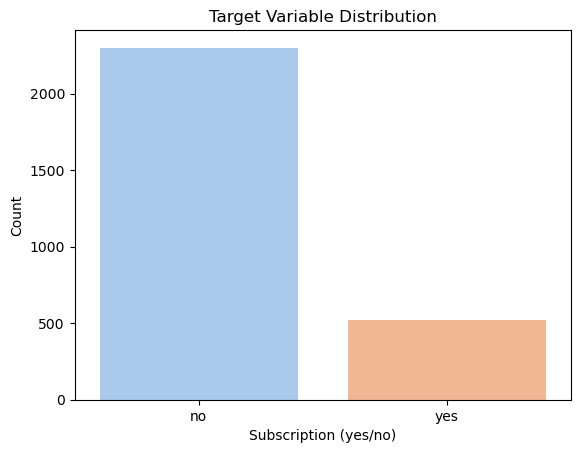

In [838]:
# The distribution of the target variable
sns.countplot(x='y', data=marketing_df, hue='y', legend=False, palette='pastel')
plt.title('Target Variable Distribution')
plt.xlabel('Subscription (yes/no)')
plt.ylabel('Count')
plt.show()

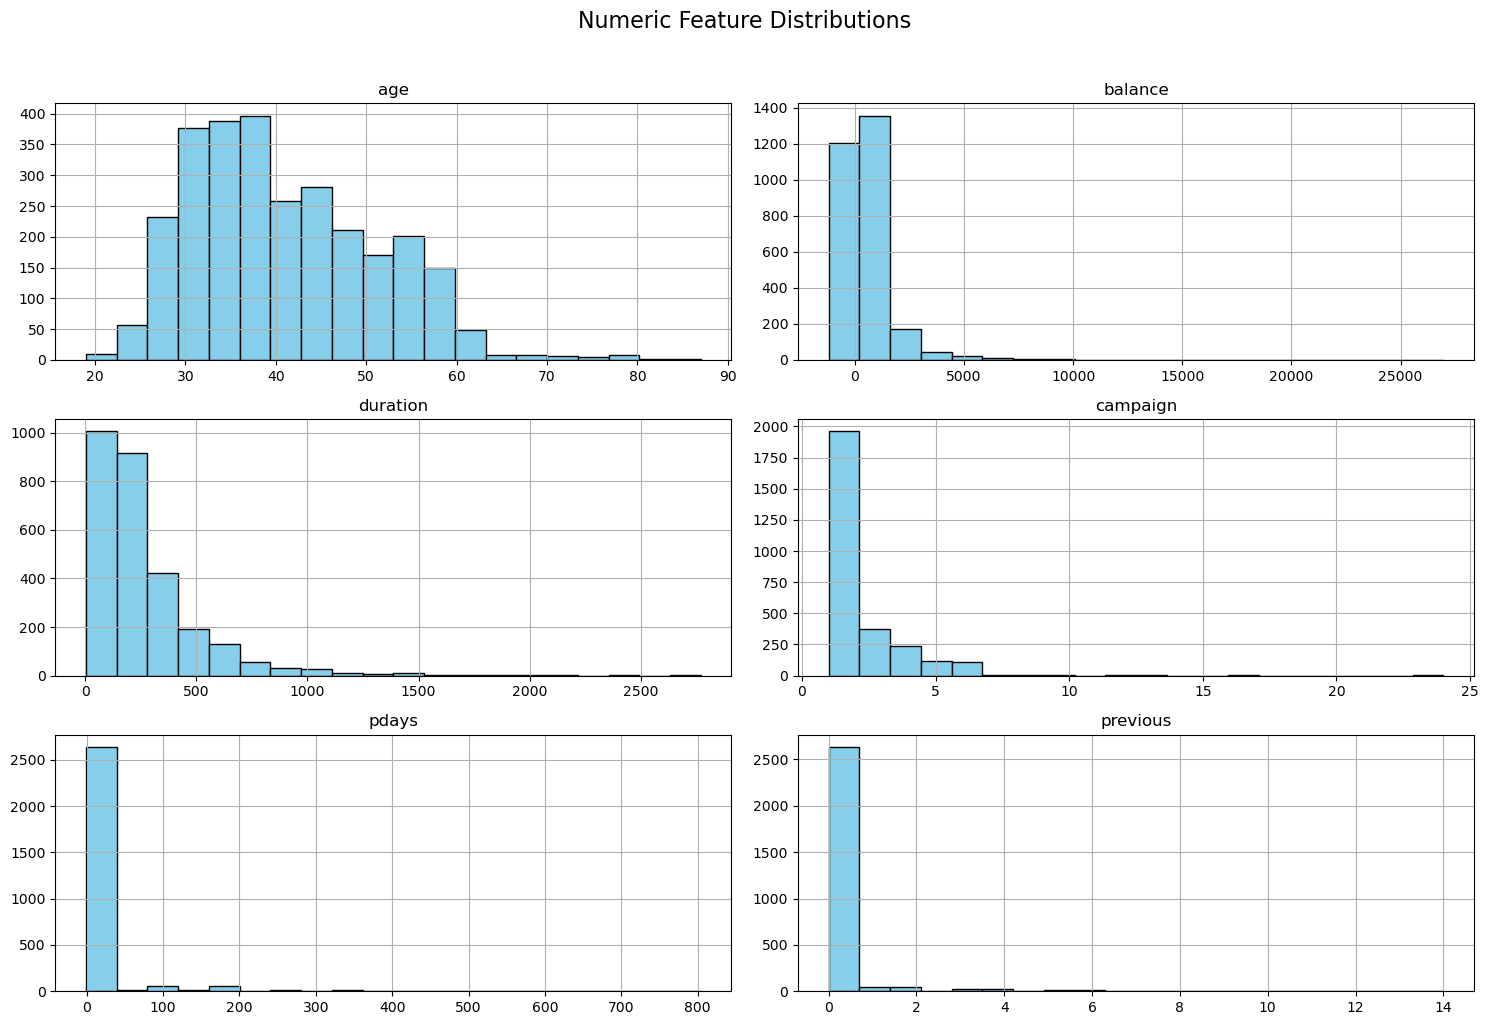

In [839]:
# Plot histograms for numeric features
marketing_df[numeric_columns].hist(bins=20, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Numeric Feature Distributions', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

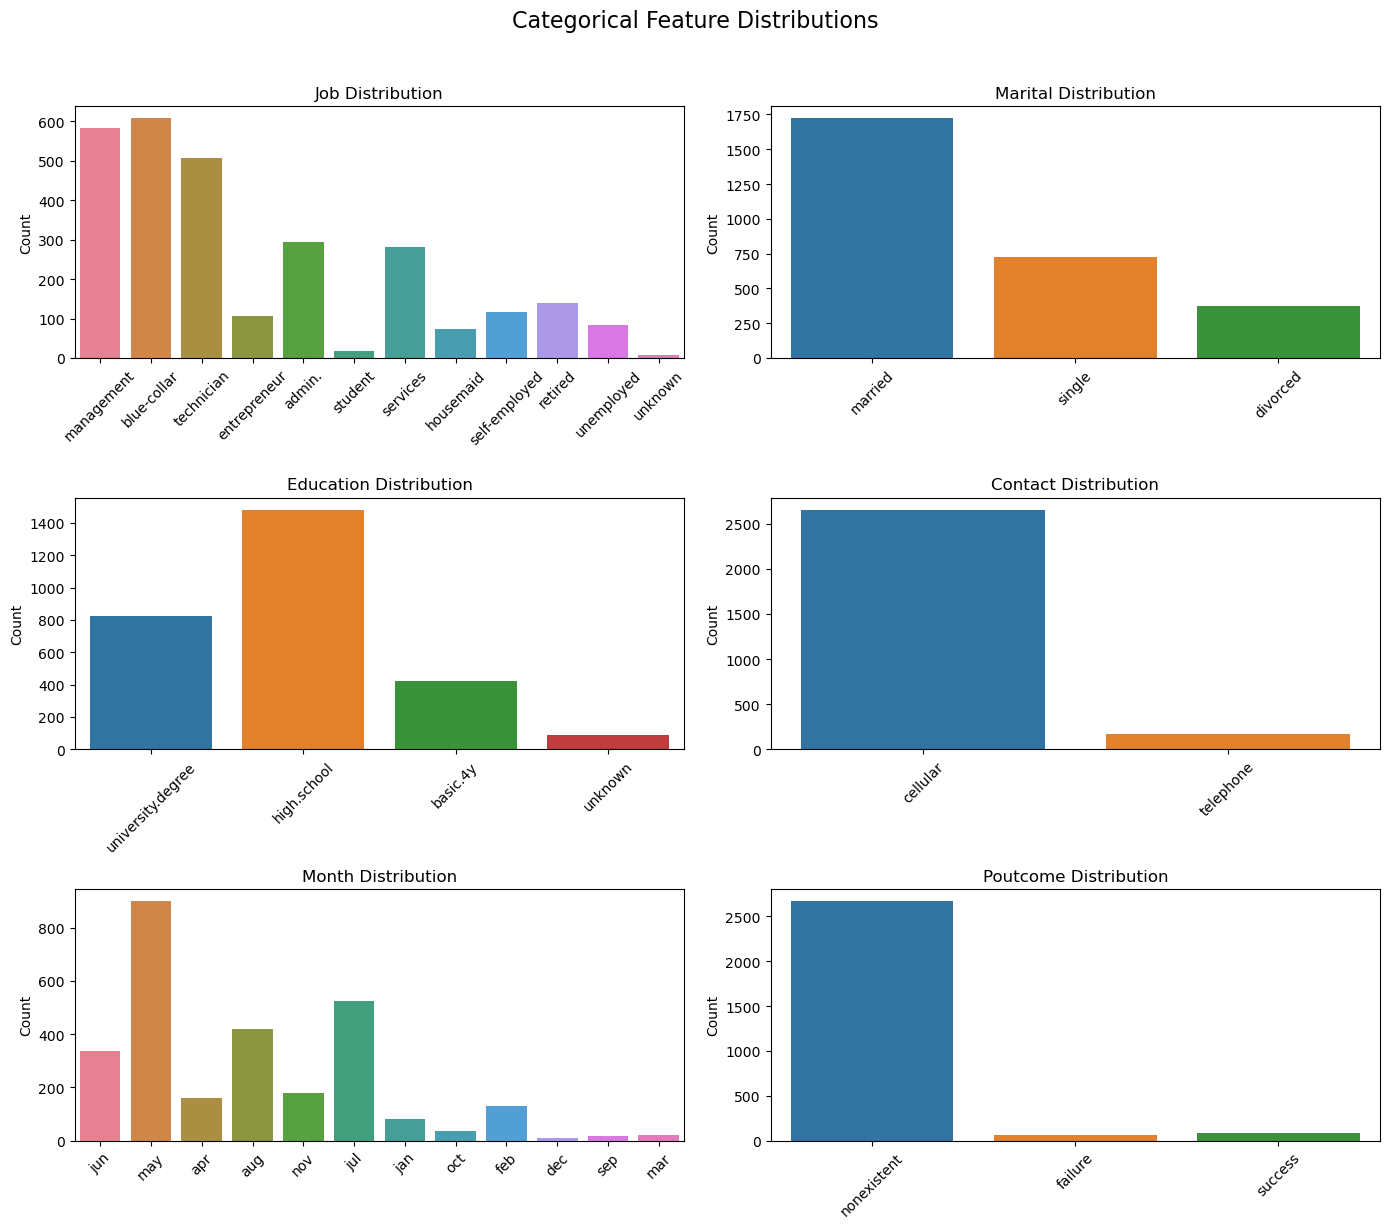

In [840]:
# Plot count plots for categorical features
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Categorical Feature Distributions', y=1.02, fontsize=16)

for ax, col in zip(axes.flatten(), categorical_columns):
    # Use a default color mapping by not specifying 'palette'
    sns.countplot(x=col, data=marketing_df, ax=ax, hue=col, legend=False)  # Use hue to color bars per category
    ax.set_title(f'{col.capitalize()} Distribution')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


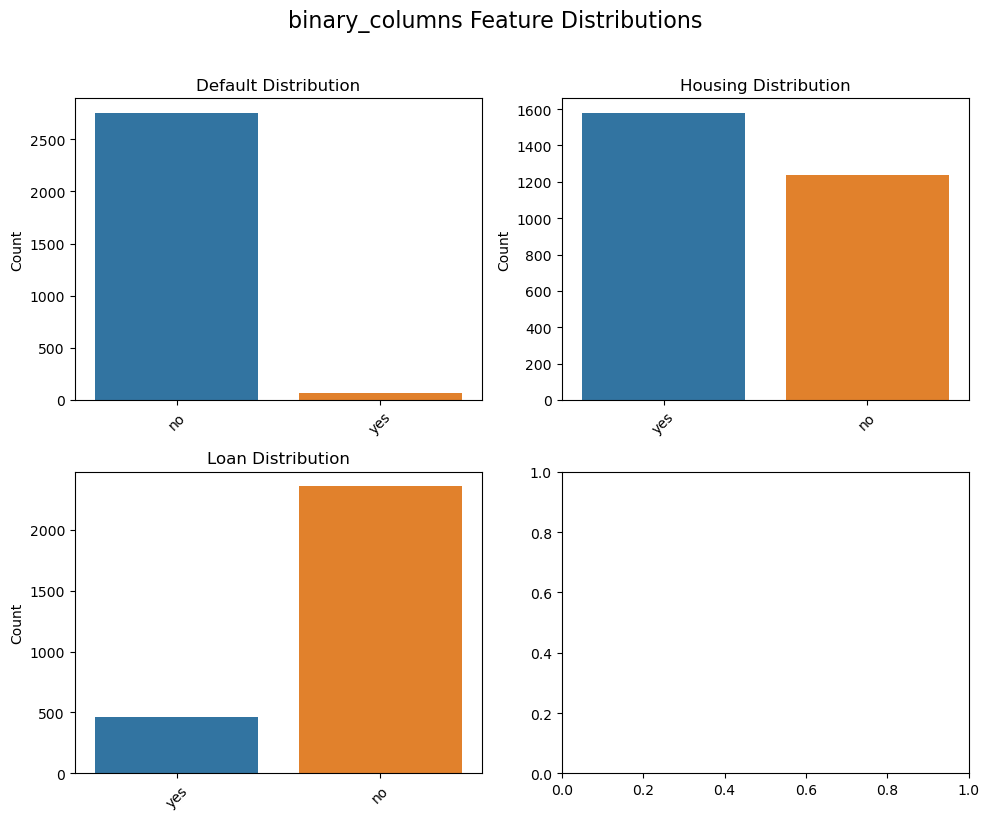

In [841]:
# Plot count plots for binary_columns features
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('binary_columns Feature Distributions', y=1.02, fontsize=16)

for ax, col in zip(axes.flatten(), binary_columns):
    # Use a default color mapping by not specifying 'palette'
    sns.countplot(x=col, data=marketing_df, ax=ax, hue=col, legend=False)  # Use hue to color bars per category
    ax.set_title(f'{col.capitalize()} Distribution')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


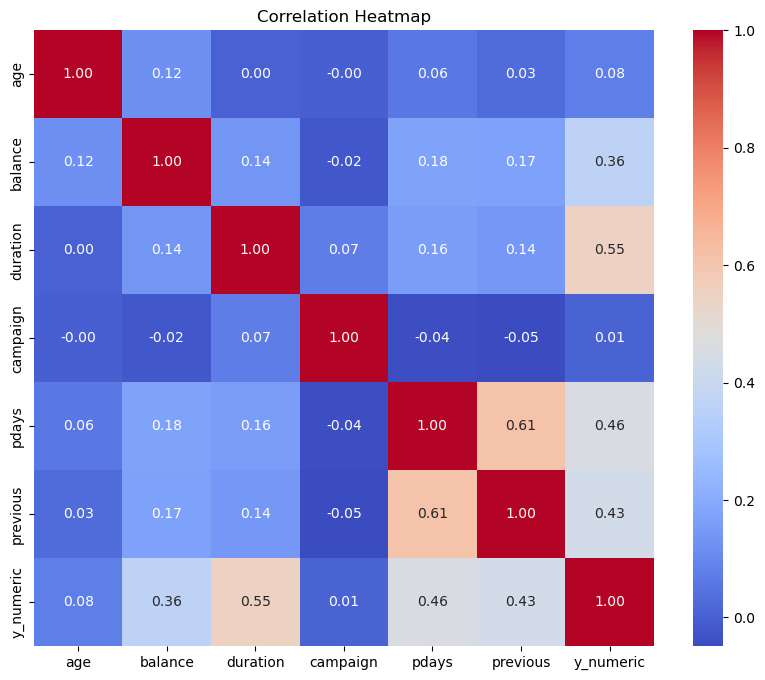

                age   balance  duration  campaign     pdays  previous  \
age        1.000000  0.120839  0.001613 -0.002284  0.059892  0.027168   
balance    0.120839  1.000000  0.135713 -0.023075  0.176113  0.172046   
duration   0.001613  0.135713  1.000000  0.073218  0.158109  0.142022   
campaign  -0.002284 -0.023075  0.073218  1.000000 -0.040719 -0.048908   
pdays      0.059892  0.176113  0.158109 -0.040719  1.000000  0.613511   
previous   0.027168  0.172046  0.142022 -0.048908  0.613511  1.000000   
y_numeric  0.076529  0.361965  0.546066  0.008244  0.458584  0.432279   

           y_numeric  
age         0.076529  
balance     0.361965  
duration    0.546066  
campaign    0.008244  
pdays       0.458584  
previous    0.432279  
y_numeric   1.000000  


In [842]:
# Plot correlation heatmap
# Convert the target column 'y' to numeric (0 and 1)
marketing_df['y_numeric'] = marketing_df['y'].map({'no': 0, 'yes': 1})

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(marketing_df[numeric_columns + ['y_numeric']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Calculate the correlation matrix
correlation_matrix = marketing_df[numeric_columns + ['y_numeric']].corr()

# Print the correlation matrix
print(correlation_matrix)

## Feature enginering and data preparation

In [844]:
# Dropping highly unbalanced features
marketing_df.drop(columns=['default', 'loan', 'poutcome', 'contact'], inplace=True)  # These features are highly unbalanced

# Dropping features with weak correlation with the target
marketing_df.drop(columns=['campaign', 'day', 'age'], inplace=True)  # Weak correlation with the target variable

# Dropping the 'duration' feature as it's only for benchmark purposes
marketing_df.drop(columns=['duration'], inplace=True)  # 'duration' should be discarded for realistic predictive models

# Drop the 'y' column as we already have 'y_numeric'
marketing_df.drop(columns=['y'], inplace=True)


In [845]:
# Verify the remaining columns
marketing_df.reset_index(drop=True, inplace=True) # Resetting the index
marketing_df.head(2)

,job,marital,education,balance,housing,month,pdays,previous,y_numeric
0,management,married,university.degree,1476,yes,jun,-1,0,0
1,blue-collar,married,high.school,0,yes,may,-1,0,0


In [846]:
# Since month is a cyclical feature (January and December are closely related), encode it using sine and cosine transformations 
# to capture the periodic nature of the months:

# Map months to numeric values (January=1, February=2, ..., December=12)
month_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

# Apply the mapping to the 'month' column
marketing_df['month_numeric'] = marketing_df['month'].map(month_mapping)

# Apply sine and cosine transformations to represent cyclical nature of 'month'
marketing_df['month_sin'] = np.sin(2 * np.pi * marketing_df['month_numeric'] / 12)
marketing_df['month_cos'] = np.cos(2 * np.pi * marketing_df['month_numeric'] / 12)

# Drop the original 'month' and 'month_numeric' columns as they are no longer needed
marketing_df = marketing_df.drop(columns=['month', 'month_numeric'])

In [847]:
# Check the transformed features
marketing_df.head(2)

,job,marital,education,balance,housing,pdays,previous,y_numeric,month_sin,month_cos
0,management,married,university.degree,1476,yes,-1,0,0,1.224647e-16,-1.000000
1,blue-collar,married,high.school,0,yes,-1,0,0,5.000000e-01,-0.866025


### Data Splitting and Feature Preprocessing Pipeline Creation

In [849]:
# Function for preparing the features and target variable (split into train and test)
def prepare_data(df, target_column='y_numeric', test_size=0.2, random_state=42):
    # Check if target column exists and drop it
    if target_column in df.columns:
        X = df.drop(columns=[target_column])
        y = df[target_column]
    else:
        raise ValueError(f"The dataset does not contain a '{target_column}' column.")
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

In [850]:
# Preprocessing function
def create_preprocessor(X, model_type='logistic_regression', degree=None):
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numerical_features = X.select_dtypes(include=['number']).columns.tolist()
    
    # Apply polynomial features only for Logistic Regression if degree is provided
    if model_type == 'logistic_regression' and degree is not None:
        poly_transformer = PolynomialFeatures(degree=degree)
    else:
        poly_transformer = None
    
    # Categorical transformer
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
    # Preprocessing pipeline for numeric and categorical features
    transformers = [
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('poly', poly_transformer) if poly_transformer else ('noop', 'passthrough')
        ]), numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
    
    preprocessor = ColumnTransformer(transformers)
    
    return preprocessor


## Models:
- **Logistic Regression (using polynomial features)**
- **K-Nearest Neighbors (KNN)**
- **Support Vector Classifier (SVC)**
- **Decision Tree Classifier**

In [852]:
##################################
## Model-1 Logistic Regression ##
#################################

# Split the data
X_train, X_test, y_train, y_test = prepare_data(marketing_df, target_column='y_numeric')

# Define parameter grid for Logistic Regression
log_params = {
    'logisticregression__C': [0.01, 0.1, 1, 10],  # Regularization parameter
    'preprocessor__num__poly__degree': [1, 2, 3]  # Polynomial degree for logistic regression
}

# Create the pipeline with the original processor
pipeline = Pipeline([
    ('preprocessor', create_preprocessor(X_train, degree=1, model_type='logistic_regression')),  # Start with degree 1
    ('logisticregression', LogisticRegression(max_iter=1000))
])

# Perform GridSearchCV to find the best parameters
log_grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=log_params,
    cv=5,
    scoring='f1',  # F1 score for imbalanced data
    n_jobs=-1
)

# Train the model
log_grid_search.fit(X_train, y_train)

# Access the best model after GridSearchCV
log_best_model = log_grid_search.best_estimator_

# Print the best parameters found by grid search
print("Best parameters found: ", log_grid_search.best_params_)


Best parameters found:  {'logisticregression__C': 10, 'preprocessor__num__poly__degree': 3}


In [853]:
###########################
### Model-1 Evaluation ####
##########################
# Split the data again (in case it's needed for this section)
X_train, X_test, y_train, y_test = prepare_data(marketing_df, target_column='y_numeric')

# Make predictions with the best model
log_y_pred = log_best_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, log_y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, log_y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       466
           1       1.00      0.58      0.74        98

    accuracy                           0.93       564
   macro avg       0.96      0.79      0.85       564
weighted avg       0.93      0.93      0.92       564

Confusion Matrix:
 [[466   0]
 [ 41  57]]


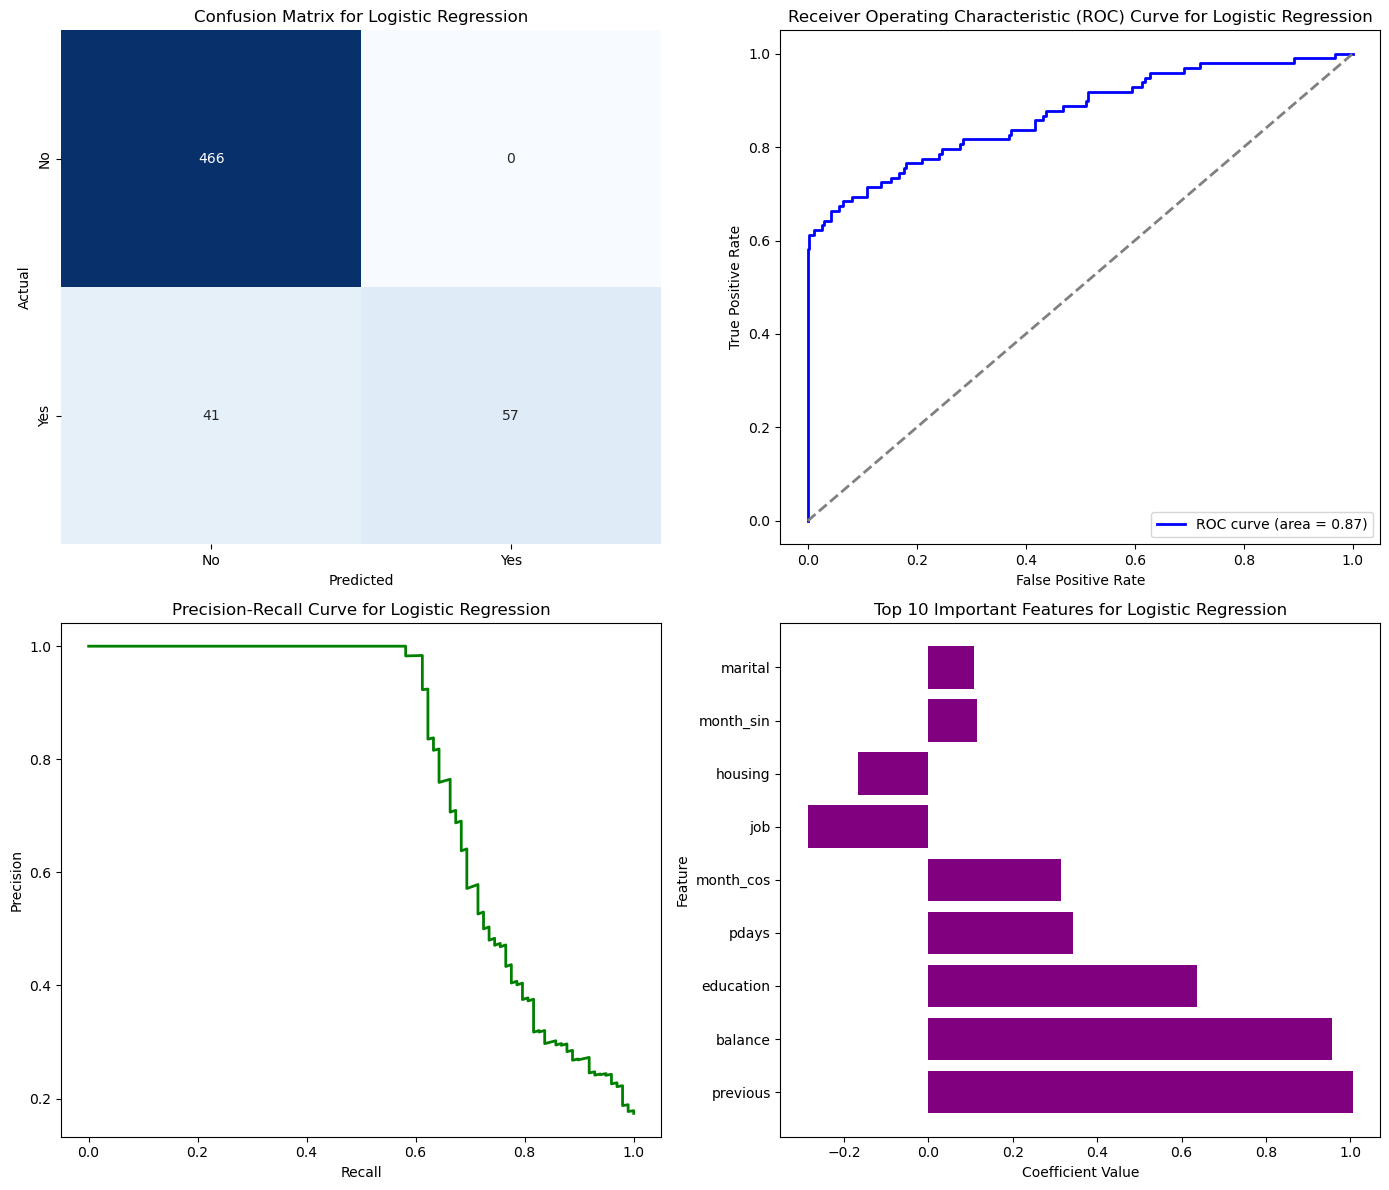

In [854]:
#############################
### Model-1 Visualization ###
#############################

# Generate confusion matrix
log_cm = confusion_matrix(y_test, log_y_pred)

# Calculate ROC curve
log_fpr, log_tpr, _ = roc_curve(y_test, log_best_model.predict_proba(X_test)[:, 1])
log_roc_auc = auc(log_fpr, log_tpr)

# Calculate Precision-Recall curve
log_precision, log_recall, _ = precision_recall_curve(y_test, log_best_model.predict_proba(X_test)[:, 1])

# Feature Importance (for Logistic Regression)
coefficients = log_best_model.named_steps['logisticregression'].coef_[0]
features = X_train.columns
feature_importance = sorted(zip(features, coefficients), key=lambda x: abs(x[1]), reverse=True)
top_features = feature_importance[:10]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Confusion Matrix
sns.heatmap(log_cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], ax=axs[0, 0])
axs[0, 0].set_title('Confusion Matrix for Logistic Regression')
axs[0, 0].set_xlabel('Predicted')
axs[0, 0].set_ylabel('Actual')

# ROC Curve
axs[0, 1].plot(log_fpr, log_tpr, color='blue', lw=2, label=f'ROC curve (area = {log_roc_auc:.2f})')
axs[0, 1].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
axs[0, 1].set_title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
axs[0, 1].set_xlabel('False Positive Rate')
axs[0, 1].set_ylabel('True Positive Rate')
axs[0, 1].legend(loc='lower right')

# Precision-Recall Curve
axs[1, 0].plot(log_recall, log_precision, color='green', lw=2)
axs[1, 0].set_title('Precision-Recall Curve for Logistic Regression')
axs[1, 0].set_xlabel('Recall')
axs[1, 0].set_ylabel('Precision')

# Feature Importance
axs[1, 1].barh([x[0] for x in top_features], [x[1] for x in top_features], color='purple')
axs[1, 1].set_title('Top 10 Important Features for Logistic Regression')
axs[1, 1].set_xlabel('Coefficient Value')
axs[1, 1].set_ylabel('Feature')

# Adjust layout
plt.tight_layout()
plt.show()


In [855]:
#################################
## Model-2 K-Nearest Neighbors ##
################################

# Split the data
X_train, X_test, y_train, y_test = prepare_data(marketing_df, target_column='y_numeric')

# Define parameter grid for KNN
knn_params = {
    'knn__n_neighbors': [3, 5, 7, 9],  # Number of neighbors
    'knn__weights': ['uniform', 'distance'],  # Weighting of neighbors
    'knn__p': [1, 2]  # Distance metric (1: Manhattan, 2: Euclidean)
}

# Create the pipeline
pipeline_knn = Pipeline([
    ('preprocessor', create_preprocessor(X_train, degree=None, model_type='knn')),  # No degree needed for KNN
    ('knn', KNeighborsClassifier())
])

# Perform GridSearchCV
knn_grid_search = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=knn_params,
    cv=5,
    scoring='f1',  # F1 score for imbalanced data
    n_jobs=-1
)

# Train the model
knn_grid_search.fit(X_train, y_train)

# Access the best model after GridSearchCV
knn_best_model = knn_grid_search.best_estimator_

# Print the best parameters found by grid search
print("Best parameters found for KNN: ", knn_grid_search.best_params_)


Best parameters found for KNN:  {'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'uniform'}


In [856]:
##########################
### Model-2 KNN Evaluation ###
##########################

# Make predictions with the best model
knn_y_pred = knn_best_model.predict(X_test)

# Print classification report
print("Classification Report for KNN:\n", classification_report(y_test, knn_y_pred))

# Print confusion matrix
print("Confusion Matrix for KNN:\n", confusion_matrix(y_test, knn_y_pred))


Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       466
           1       0.96      0.50      0.66        98

    accuracy                           0.91       564
   macro avg       0.93      0.75      0.80       564
weighted avg       0.91      0.91      0.90       564

Confusion Matrix for KNN:
 [[464   2]
 [ 49  49]]


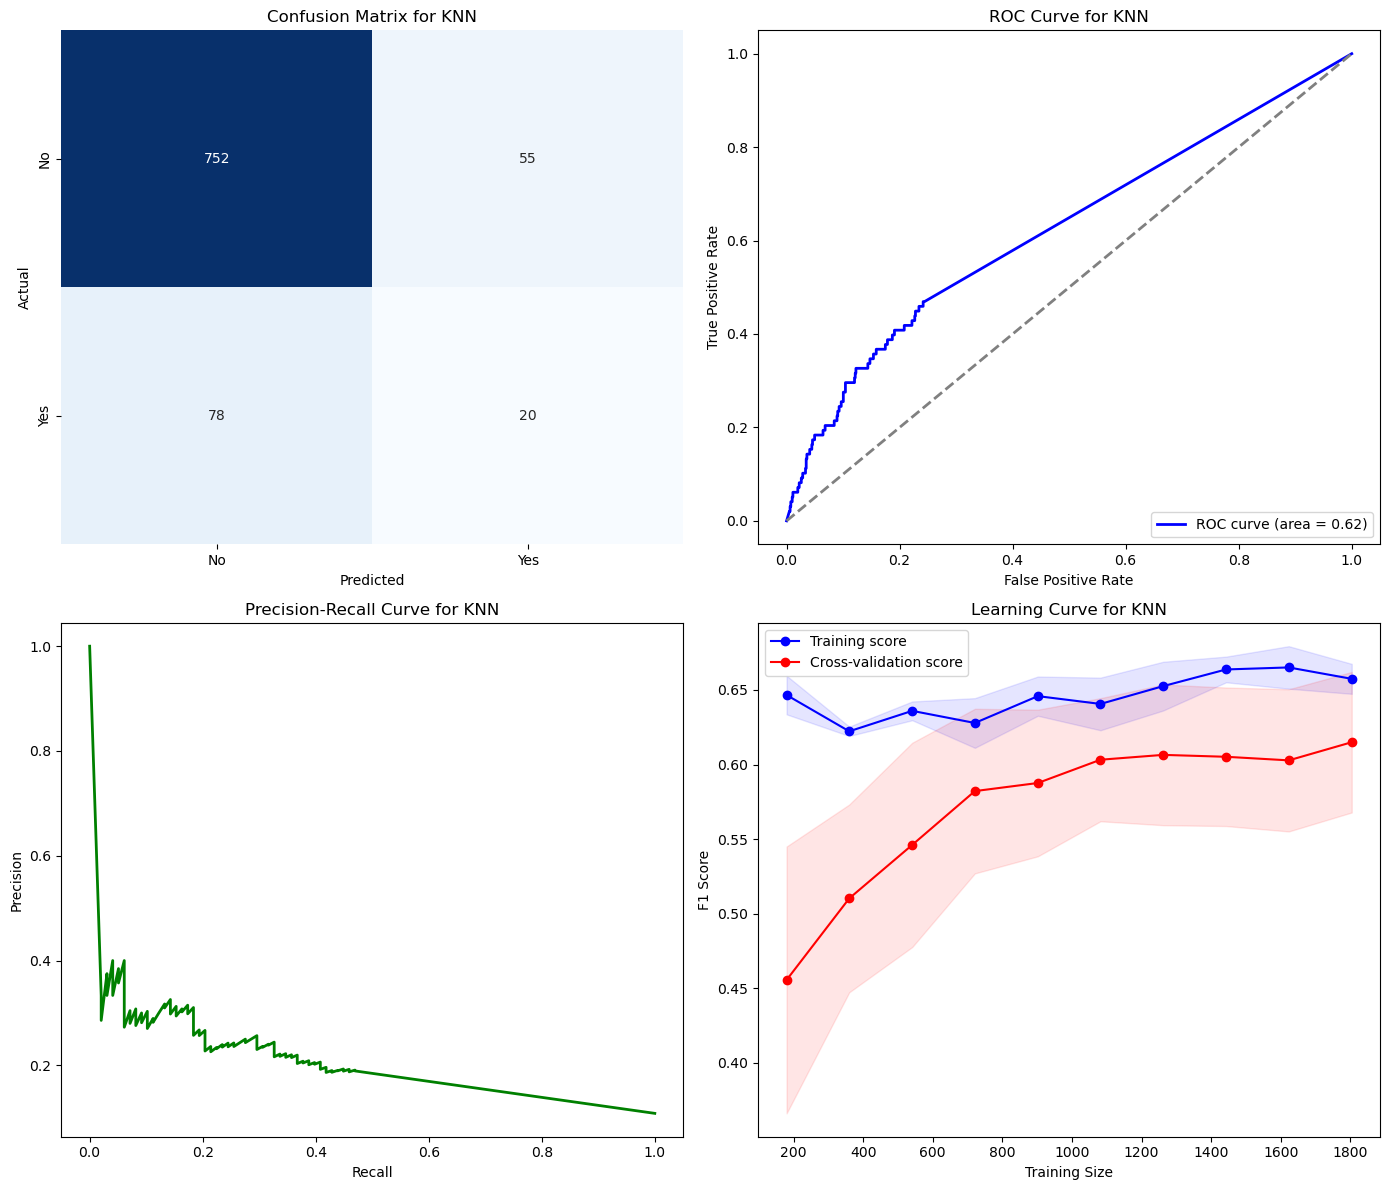

In [857]:
# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    knn_best_model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Create subplots with 4 plots
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Existing plots (Confusion Matrix, ROC Curve, Precision-Recall Curve)
# Confusion Matrix
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], ax=axs[0, 0])
axs[0, 0].set_title('Confusion Matrix for KNN')
axs[0, 0].set_xlabel('Predicted')
axs[0, 0].set_ylabel('Actual')

# ROC Curve
axs[0, 1].plot(knn_fpr, knn_tpr, color='blue', lw=2, label=f'ROC curve (area = {knn_roc_auc:.2f})')
axs[0, 1].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
axs[0, 1].set_title('ROC Curve for KNN')
axs[0, 1].set_xlabel('False Positive Rate')
axs[0, 1].set_ylabel('True Positive Rate')
axs[0, 1].legend(loc='lower right')

# Precision-Recall Curve
axs[1, 0].plot(knn_recall, knn_precision, color='green', lw=2)
axs[1, 0].set_title('Precision-Recall Curve for KNN')
axs[1, 0].set_xlabel('Recall')
axs[1, 0].set_ylabel('Precision')

# Learning Curve
axs[1, 1].plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
axs[1, 1].plot(train_sizes, test_mean, 'o-', color='red', label='Cross-validation score')
axs[1, 1].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
axs[1, 1].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')
axs[1, 1].set_title('Learning Curve for KNN')
axs[1, 1].set_xlabel('Training Size')
axs[1, 1].set_ylabel('F1 Score')
axs[1, 1].legend(loc='best')

plt.tight_layout()
plt.show()


In [858]:
################################################
### Model-3: Support Vector Classifier (SVC) ###
################################################

# Split the data
X_train, X_test, y_train, y_test = prepare_data(marketing_df, target_column='y_numeric')

# Define the parameter grid for SVC
svc_params = {
    'svc__C': [0.1, 1, 10],   # Regularization parameter
    'svc__gamma': [1, 0.1, 0.01, 0.001],  # Kernel coefficient for 'rbf'
    'svc__kernel': ['linear', 'rbf']  # Kernel types
}

# Create the pipeline for SVC
svc_pipeline = Pipeline([
    ('preprocessor', create_preprocessor(X_train)),  # No polynomial features needed for SVC
    ('svc', SVC(probability=True))  # Enable probability estimates for ROC curve
])

# Perform GridSearchCV
svc_grid_search = GridSearchCV(
    estimator=svc_pipeline,
    param_grid=svc_params,
    cv=5,
    scoring='f1',  # F1 score for imbalanced data
    n_jobs=-1
)

# Train the model
svc_grid_search.fit(X_train, y_train)

# Save the best model
svc_best_model = svc_grid_search.best_estimator_

# Print the best parameters found by GridSearchCV
print("Best parameters found for SVC: ", svc_grid_search.best_params_)


Best parameters found for SVC:  {'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


In [859]:
################################################
### Model-3 Evaluation #########################
################################################

# Make predictions with the best SVC model
svc_y_pred = svc_best_model.predict(X_test)

# Print evaluation metrics
print("Classification Report:\n", classification_report(y_test, svc_y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, svc_y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       466
           1       0.97      0.58      0.73        98

    accuracy                           0.92       564
   macro avg       0.94      0.79      0.84       564
weighted avg       0.93      0.92      0.92       564

Confusion Matrix:
 [[464   2]
 [ 41  57]]


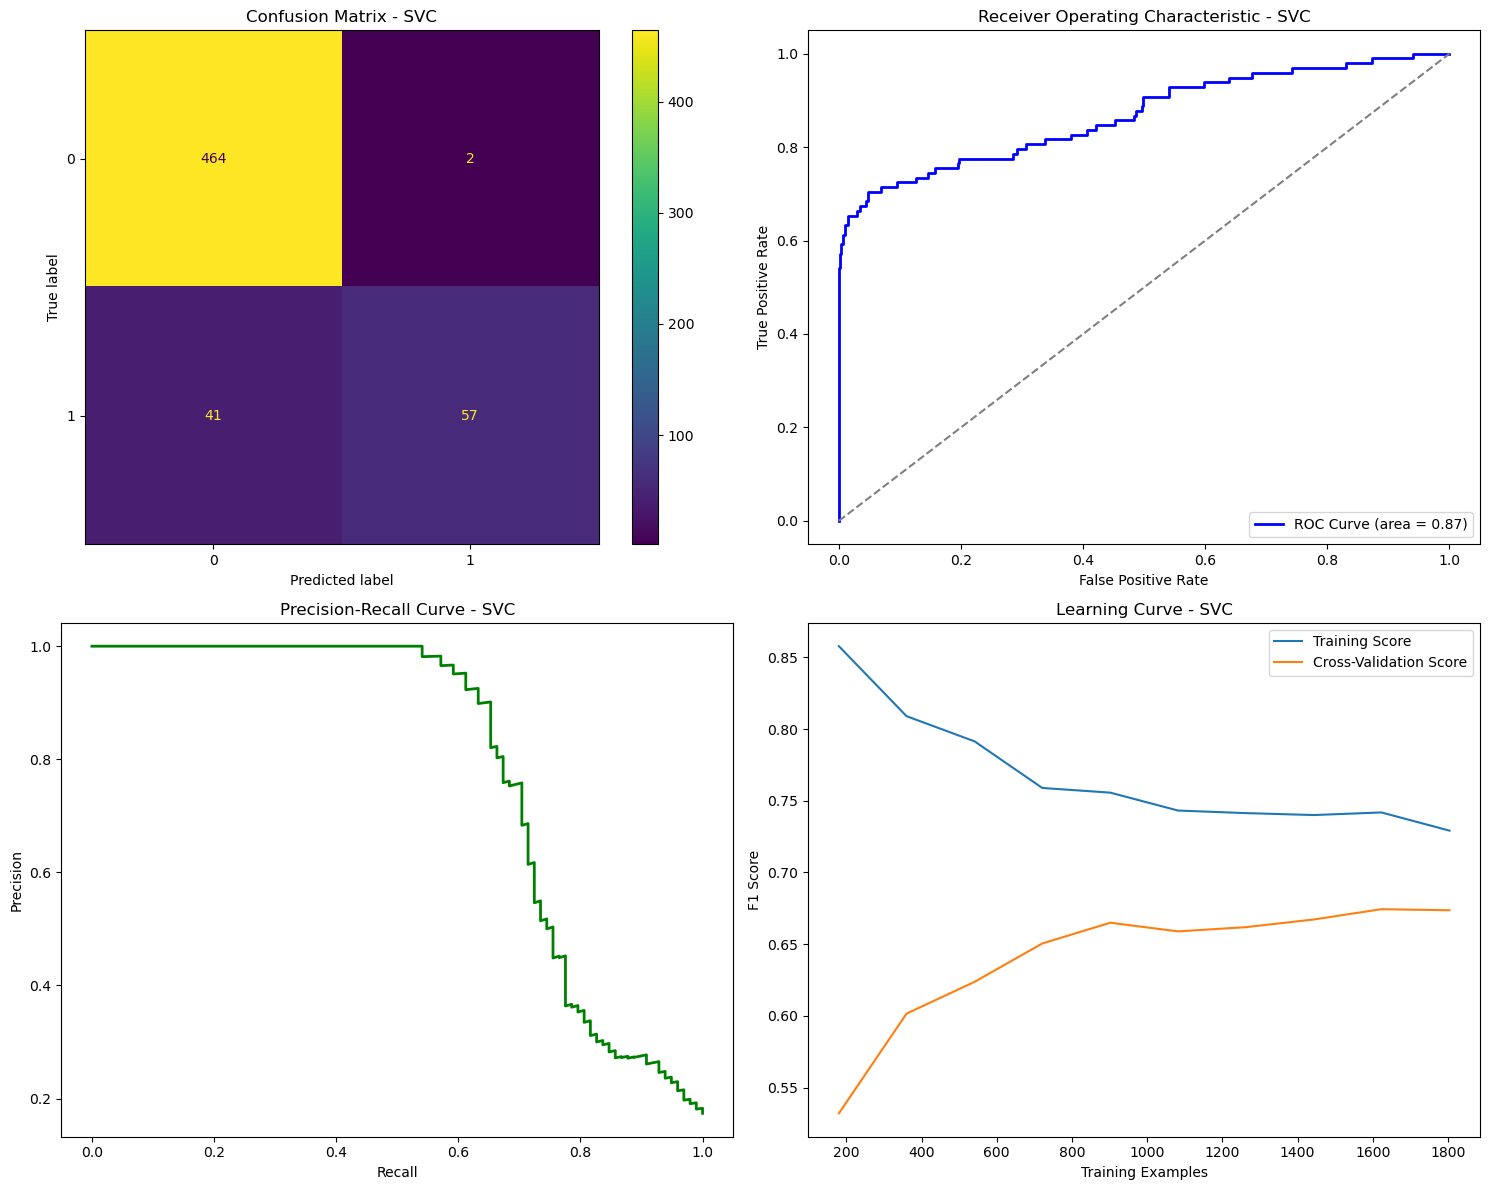

In [860]:
###############################
### Model-3: Visualization (SVC) ###
###############################

# Import necessary libraries
from sklearn.metrics import roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix (top-left)
ConfusionMatrixDisplay.from_estimator(svc_best_model, X_test, y_test, ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix - SVC')

# ROC Curve (top-right)
svc_y_prob = svc_best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, svc_y_prob)
roc_auc = auc(fpr, tpr)
axes[0, 1].plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (area = %0.2f)' % roc_auc)
axes[0, 1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('Receiver Operating Characteristic - SVC')
axes[0, 1].legend(loc='lower right')

# Precision-Recall Curve (bottom-left)
precision, recall, _ = precision_recall_curve(y_test, svc_y_prob)
axes[1, 0].plot(recall, precision, color='green', lw=2)
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve - SVC')

# Learning Curve (bottom-right)
train_sizes, train_scores, test_scores = learning_curve(
    svc_best_model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

axes[1, 1].plot(train_sizes, train_mean, label='Training Score')
axes[1, 1].plot(train_sizes, test_mean, label='Cross-Validation Score')
axes[1, 1].set_title("Learning Curve - SVC")
axes[1, 1].set_xlabel("Training Examples")
axes[1, 1].set_ylabel("F1 Score")
axes[1, 1].legend()

# Adjust the layout to avoid overlapping
plt.tight_layout()
plt.show()


In [861]:
####################################
### Model-4: Decision Tree      ###
####################################

# Split the data
X_train, X_test, y_train, y_test = prepare_data(marketing_df, target_column='y_numeric')

# Define the parameter grid for Decision Tree
dt_params = {
    'decisiontreeclassifier__max_depth': [3, 5, 10, 15],  # Maximum depth of tree
    'decisiontreeclassifier__min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 4],  # Minimum samples required to be at a leaf node
}

# Create the pipeline for Decision Tree
dt_pipeline = Pipeline([
    ('preprocessor', create_preprocessor(X_train)),  # No polynomial features needed for Decision Tree
    ('decisiontreeclassifier', DecisionTreeClassifier(random_state=42))  # Decision Tree Classifier
])

# Perform GridSearchCV for hyperparameter tuning
dt_grid_search = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=dt_params,
    cv=5,
    scoring='f1',  # F1 score for imbalanced data
    n_jobs=-1
)

# Train the model
dt_grid_search.fit(X_train, y_train)

# Save the best model
dt_best_model = dt_grid_search.best_estimator_

# Print the best parameters found by GridSearchCV
print("Best parameters found for Decision Tree: ", dt_grid_search.best_params_)


Best parameters found for Decision Tree:  {'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 10}


In [862]:
####################################
### Model-4: Evaluation (Decision Tree) ###
####################################

# Make predictions with the best model
dt_y_pred = dt_best_model.predict(X_test)

# Print classification report
print("Classification Report:\n", classification_report(y_test, dt_y_pred))

# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95       466
           1       0.91      0.60      0.72        98

    accuracy                           0.92       564
   macro avg       0.91      0.79      0.84       564
weighted avg       0.92      0.92      0.91       564

Confusion Matrix:
 [[460   6]
 [ 39  59]]


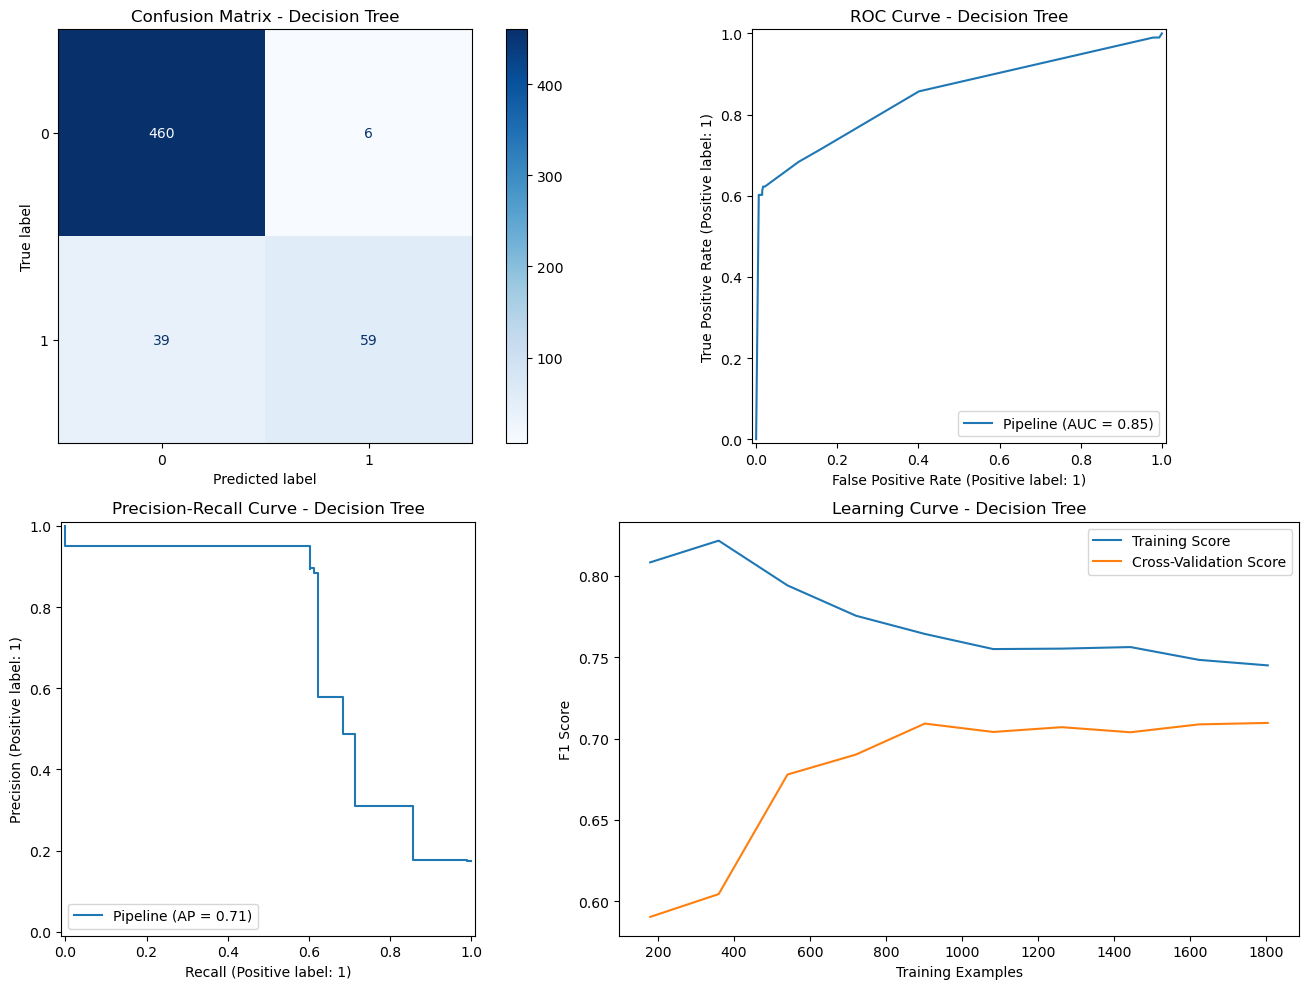

In [863]:
##################################
### Model-4: Visualization (Decision Tree) ###
##################################

# Import necessary libraries
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import learning_curve

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(dt_best_model, X_test, y_test, cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title("Confusion Matrix - Decision Tree")

# Plot ROC Curve
RocCurveDisplay.from_estimator(dt_best_model, X_test, y_test, ax=axes[0, 1])
axes[0, 1].set_title("ROC Curve - Decision Tree")

# Plot Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(dt_best_model, X_test, y_test, ax=axes[1, 0])
axes[1, 0].set_title("Precision-Recall Curve - Decision Tree")

# Plot Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    dt_best_model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

axes[1, 1].plot(train_sizes, train_mean, label='Training Score')
axes[1, 1].plot(train_sizes, test_mean, label='Cross-Validation Score')
axes[1, 1].set_title("Learning Curve - Decision Tree")
axes[1, 1].set_xlabel("Training Examples")
axes[1, 1].set_ylabel("F1 Score")
axes[1, 1].legend()

# Show all plots
plt.tight_layout()
plt.show()


In [864]:
# Initialize or load metrics_df if not already created
metrics_df = pd.DataFrame()

# Function to extract all metrics for each model
def update_metrics(model_name, best_model, grid_search, X_train, X_test, y_train, y_test):
    # Predictions and probabilities
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # For ROC-AUC, assuming binary classification
    
    # Calculate the scores
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)
    avg_fit_time = grid_search.cv_results_['mean_fit_time'].mean()
    
    # Additional metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)  # Optional for reporting
    
    # Create a new DataFrame row with all metrics
    new_row = pd.DataFrame({
        'Model': [model_name],
        'Train Score': [train_score],
        'Test Score': [test_score],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1],
        'ROC AUC': [roc_auc],
        'Average Fit Time (s)': [avg_fit_time]
    })
    
    # Concatenate the new row with the existing DataFrame
    global metrics_df
    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

# Update metrics for each model
update_metrics('Logistic Regression', log_best_model, log_grid_search, X_train, X_test, y_train, y_test)
update_metrics('K-Nearest Neighbors', knn_best_model, knn_grid_search, X_train, X_test, y_train, y_test)
update_metrics('Support Vector Classifier', svc_best_model, svc_grid_search, X_train, X_test, y_train, y_test)
update_metrics('Decision Tree', dt_best_model, dt_grid_search, X_train, X_test, y_train, y_test)

# Display the updated DataFrame with all metrics
metrics_df


,Model,Train Score,Test Score,Accuracy,Precision,Recall,F1 Score,ROC AUC,Average Fit Time (s)
0,Logistic Regression,0.915337,0.927305,0.927305,1.000000,0.581633,0.735484,0.869055,0.046729
1,K-Nearest Neighbors,0.901596,0.909574,0.909574,0.960784,0.500000,0.657718,0.809495,0.013146
2,Support Vector Classifier,0.919770,0.923759,0.923759,0.966102,0.581633,0.726115,0.867435,0.873208
3,Decision Tree,0.921986,0.920213,0.920213,0.907692,0.602041,0.723926,0.848099,0.019905


# Understanding the Business Problem

## Business Problem:
The goal of this project is to predict whether a client of a Portuguese banking institution will subscribe to a term deposit, based on various customer features. This is a binary classification problem, where the target variable (`y`) is 1 if the client subscribes and 0 if they do not. The features include personal details (such as age, marital status, and education), bank account information (such as balance, housing loan, and previous interactions), and campaign-related variables (like the day of the month, duration of contact, and previous contact history). Understanding which features influence the likelihood of subscription can help optimize marketing efforts, target the right clients, and improve the efficiency of future campaigns.

---

# Descriptive and Inferential Statistics

## Descriptive Statistics:

### Correlations:
- The features show various relationships with each other. For example, `previous` (the number of contacts during the previous campaign) has a moderate positive correlation with `pdays` (the number of days since the client was last contacted) and a low positive correlation with the target variable (`y`).
- Other features like `balance`, `age`, and `duration` have weaker correlations with the target.

### Target Variable Insights:
- The target variable `y` is imbalanced, with a lower percentage of clients subscribing to the term deposit (1) compared to those who do not (0). This imbalance needs to be addressed to prevent biased models that over-predict the majority class.

---

## Inferential Statistics:

### Feature Importance:
- Some features like `duration` (call duration in seconds) are highly correlated with the target variable. However, this feature should not be used in predictive modeling due to its post-contact nature, which makes it unrealistic for predicting subscription before the call is made.
- Features like `previous` and `pdays` also provide some predictive value.

### Imbalance:
- The class imbalance issue is crucial and suggests that focusing on improving the recall metric might be necessary, as many models have low recall rates (e.g., Logistic Regression’s recall of 10.20%). This indicates that a significant portion of clients who actually subscribe is being missed by the model.

---

# Findings and Actionable Insights

## Model Performance:
- **Logistic Regression** performed the best in terms of accuracy, with reasonable train and test scores. However, it showed a very low recall, meaning it missed a lot of actual term deposit subscribers.
- The **Decision Tree** and **K-Nearest Neighbors** models exhibited overfitting, which reduced their generalization ability on the test data.

## Feature Analysis:
- **Duration:** While this feature is highly correlated with the target, it should not be used in the model as it is known only after a call is made. A more realistic approach would involve focusing on features that are available before making contact, such as `previous` and `pdays`.
- **Imbalance:** The class imbalance issue is evident in all models, with many models performing poorly in terms of recall. Addressing this issue by using techniques like resampling, adjusting class weights, or using metrics such as Precision-Recall AUC could improve model performance.
- **Marketing Insight:** The features that could help target the right clients include those related to previous campaigns (`previous` and `pdays`), as well as personal features like `balance` and `age`. For example, clients with higher balances and more previous interactions might be more likely to subscribe, which could inform the targeting strategy.

---

# Next Steps and Recommendations

## Model Refinement:
- Focus on improving recall by adjusting the class weights or employing resampling techniques (SMOTE or undersampling).
- Experiment with other models such as **Random Forest** or **Gradient Boosting**, which can handle class imbalance better.

## Feature Engineering:
- Consider interaction terms between features (e.g., `balance` and `age`) or non-linear transformations of continuous variables.

## Evaluation Metrics:
- Since the business problem is to predict whether a client will subscribe to a term deposit, focus on metrics that account for class imbalance.
- In addition to accuracy, use **recall**, **precision**, **F1 score**, and **ROC AUC**. A balanced approach is needed to ensure the model doesn't miss too many positive cases.

## Deployment Considerations:
- When deploying the model for real-time use, ensure that it makes predictions based on available data at the time of the contact.
- Models using post-contact information (like `duration`) should be avoided in production.

---

# Conclusion:
By implementing these steps, you can refine the model, better target clients for term deposit subscriptions, and optimize marketing resources.
